 - utiliser juste deux classes : keep / reject
 - multi-variate X en fonction du dictionaire incluant list_keys_param_fit et goodness_of_fit


In [1]:
import numpy as np
import matplotlib.pyplot as plt
#from sklearn import svm, datasets
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')  # "error", "ignore", "always", "default", "module" or "once"

In [2]:
#------------------------------------------------------------------------------
# 1- Split into a training set and a test set using a ShuffleSplit + doing that in parallel for the differrent features to test
#------------------------------------------------------------------------------

from sklearn.model_selection import ShuffleSplit
def split_data(X, y, test_size=.25, train_size=None) :
    

    rs = ShuffleSplit(n_splits=1, test_size=test_size, train_size=train_size, random_state=0)
    for index_train, index_test in rs.split(y): pass

    X_train, X_test = {}, {}
    X_train, X_test = X[index_train, :], X[index_test, :]
    y_train, y_test =  y[index_train].copy(), y[index_test].copy()

    print('nb_trial_train : X: %s, y: %s'%(X_train.shape[0], y_train.shape[0]), end='\t')
    print('nb_trial_test : X: %s,  y: %s'%(X_test.shape[0], y_test.shape[0]))
    return X_train, X_test, y_train, y_test

In [3]:
#------------------------------------------------------------------------------
# 4- Train a SVM classification model
#------------------------------------------------------------------------------

from sklearn.grid_search import GridSearchCV # see http://scikit-learn.org/stable/modules/grid_search.html
from sklearn.svm import SVC

def Train_SVM(X_train, y_train, size_c_gamma=32, ax=None, fig=None, plot=None) :


    C_range = np.logspace(-5, 10., size_c_gamma, base=2.)
    gamma_range = np.logspace(-14, 3, size_c_gamma, base=2.)

    

    '''param_grid = [{'kernel': ['rbf', 'poly', 'sigmoid'], 'gamma': gamma_range, 'C': C_range},
                  {'kernel': ['linear'], 'C': C_range}]'''
    
    liste_kernel = ['rbf']#, 'poly', 'sigmoid']
    param_grid = [{'kernel': liste_kernel, 'gamma': gamma_range, 'C': C_range}]

    
    grid = GridSearchCV(SVC(verbose=False, tol=1e-3, max_iter = -1, ),
                        param_grid, verbose=0, scoring='f1_weighted', n_jobs=1,) #cv=50, 

    X_train_ = np.zeros((len(X_train), 0))
    X_train_ = np.hstack((X_train_, X_train))
    grid.fit(X_train, y_train.ravel())


    # plot the scores of the grid
    score_dict = grid.grid_scores_ # grid_scores_ contains parameter settings and scores
    
    scores_mean, scores_std ={}, {}
    for params, mean_score, scores in score_dict:
        try :
            scores_mean[params['kernel']].append(scores.mean())
            scores_std[params['kernel']].append(scores.std()/2)
        except:
            scores_mean[params['kernel']] = []
            scores_std[params['kernel']] = []
            scores_mean[params['kernel']].append(scores.mean())
            scores_std[params['kernel']].append(scores.std()/2)


    # draw heatmap of accuracy as a function of gamma and C    
    if plot is None :
        fig, ax = plt.subplots(1,1,figsize=(5,5))

    for x, k in enumerate(['rbf']): #, 'poly', 'sigmoid']) :
        scores = np.array(scores_mean[k]).reshape((gamma_range.shape[0], C_range.shape[0]))
        im = ax.imshow(scores, interpolation='nearest', cmap=plt.cm.gray)
        ax.set_xlabel('gamma')
        ax.set_ylabel('C')
        #ax.set_colorbar()
        ax.set_title(k)
        fig.colorbar(im, ax=ax, pad=0.01, fraction=.047)
    
    if plot is None :
        fig.tight_layout()
        plt.show()
    
    print("The best parameters are %s with a score of %0.2f" % (grid.best_params_, grid.best_score_))
    
    if plot is None :
        return grid
    else :
        return ax, fig, grid

/home/phantom/.local/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/home/phantom/.local/lib/python3.6/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [4]:
#------------------------------------------------------------------------------
# 5- Quantitative evaluation of the model quality on the test set
#------------------------------------------------------------------------------
def Quantitative_evaluation(grid, X_test, y_test, classes, ax=None, fig=None, plot=None) :

    import itertools
    from sklearn import metrics
    from sklearn.metrics import classification_report
    from sklearn.metrics import confusion_matrix

    
    y_pred = grid.predict(X_test)
    # see https://en.wikipedia.org/wiki/F1_score
    fone_score = np.array(metrics.f1_score(y_test, y_pred, average=None)).mean()
    
    #print("Predicting the category names on the testing set")
    #print('\nclassification_report on test \n', classification_report(y_test, y_pred, target_names=classes))
    
    
    cm = confusion_matrix(y_test, y_pred)
    norm_cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    if plot is None :
        fig, ax = plt.subplots(1,1,figsize=(5,5))
    im = ax.imshow(norm_cm, interpolation='nearest', cmap=plt.cm.Reds)
    
    ax.set_title('Confusion matrix\n(fone_score on test => Accuracy = %0.2f)' % (fone_score))
    fig.colorbar(im, ax=ax, pad=0.01, fraction=.047)
    
    tick_marks = np.arange(len(classes))
    ax.set_xticks(tick_marks)
    ax.set_yticks(tick_marks)
    ax.set_xticklabels(classes)
    ax.set_yticklabels(classes)
    
    thresh = norm_cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        ax.text(j, i, 'nb_trial = %s\n\n(%.0f %%)'%(cm[i, j], norm_cm[i, j]*100),
                 horizontalalignment="center",
                 color="white" if norm_cm[i, j] > thresh else "black")
        if i==j :
            ax.text(j, i+0.2, 'f1_score = %.2f'%(metrics.f1_score(y_test, y_pred, average=None)[i]),
                 horizontalalignment="center",
                 color="white" if norm_cm[i, j] > thresh else "black")
        

    ax.set_ylabel('True label')
    ax.set_xlabel('Predicted label')
    
    if plot is None :
        plt.tight_layout()
        plt.show()

        return y_pred
    else :
        return ax, fig, y_pred

# Data

In [5]:
import pickle
import os
from ANEMO import read_edf
from ANEMO import ANEMO
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
sujet = ['AM','BMC','CS','DC','FM','IP','LB','OP','RS','SR','TN','YK']
time = ['2017-10-23_100057','2017-09-26_095637', '2017-10-03_134421','2017-09-27_161040',
        '2017-10-03_143803','2017-09-28_115250', '2017-09-20_151043','2017-10-26_121823',
        '2017-11-08_094717','2017-11-16_153313', '2017-11-08_150410','2017-11-17_172706']
file = os.path.join('parametre', 'Delete_list_trials_velocity_fct.pkl')
with open(file, 'rb') as fichier :
    Delete_list_trials = pickle.load(fichier, encoding='latin1')

file = os.path.join('parametre', 'Delete_list_Bad_trials_velocity.pkl')
with open(file, 'rb') as fichier :
    Bad_Fit = pickle.load(fichier, encoding='latin1')

In [6]:
list_keys_param_fit = ['start_anti', 'tau', 'a_anti', 'latency', 'maxi']
X, y, var = [], [], []
a = 0
for x in range(len(sujet)) :
    
    #-------------------------------------------------------------------------
    file = os.path.join('data', 'enregistrement_' + sujet[x] + '_' + time[x] + '.pkl')
    with open(file, 'rb') as fichier : param_exp = pickle.load(fichier, encoding='latin1')
    A = ANEMO(param_exp)
    N_trials, N_blocks = param_exp['N_trials'], param_exp['N_blocks']

    resultats = os.path.join('data', 'enregistrement_' + sujet[x] + '_' + time[x] + '.asc')
    data = read_edf(resultats, 'TRIALID')

    file = os.path.join('parametre/goodness_of_fit/goodness_of_fit_'+ sujet[x] +'.pkl')
    with open(file, 'rb') as fichier : goodness_of_fit = pickle.load(fichier, encoding='latin1')
    
    file = os.path.join('parametre/param_Fit_'+ sujet[x] +'_fct_velocity_2_step_False_whitening.pkl')
    with open(file, 'rb') as fichier : param_fit = pickle.load(fichier, encoding='latin1')
    #-------------------------------------------------------------------------

    nb_del_trial = [len(Delete_list_trials[sujet[x]][b]) for b in range(N_blocks)]
    nb_bad_trial = [len(Bad_Fit[sujet[x]][b]) for b in range(N_blocks)]
    print('%s -- nb_Delete_trials = %s, nb_Bad_Fit = %s'%(sujet[x], nb_del_trial, nb_bad_trial))
    #-------------------------------------------------------------------------
    
    for block in range(N_blocks) :
        for trial in range(N_trials) :

            if trial in Delete_list_trials[sujet[x]][block] : y.append(1)
            elif trial in Bad_Fit[sujet[x]][block] : y.append(1)
            else : y.append(0)

            if a==0 :
                var.append('nb_nan') ; X.append([])
                var.append('residu') ; X.append([])
                for key in goodness_of_fit.keys() :
                    if key!='residual' : var.append(key) ; X.append([])
                for key in param_fit.keys() :
                    if key in list_keys_param_fit : var.append(key) ; X.append([])
                a=1
            
            trial_data = trial + N_trials*block
            arg = A.arg(data[trial_data], trial=trial, block=block)
            velocity_NAN = A.velocity_NAN(**arg)

            nb_nan = [x for x in velocity_NAN[arg.StimulusOf-arg.t_0:] if str(x)=='nan']
            X[0].append(len(nb_nan)/len(velocity_NAN[arg.StimulusOf-arg.t_0:]))
            
            t1 , res = 0, np.zeros(len(velocity_NAN)-280)
            for t in range(len(velocity_NAN)-280) :
                if np.isnan(velocity_NAN[t]) : res[t] = np.nan
                else : res[t] = abs(goodness_of_fit['residual'][block][trial][t1]) ; t1 = t1+1
            residu = np.nanmean(res[arg.StimulusOf-arg.t_0:])
            
            X[1].append(residu)
            
            k = 2
            for key in goodness_of_fit.keys() :
                if key!='residual' : X[k].append(goodness_of_fit[key][block][trial]) ; k=k+1
    
            for key in param_fit.keys() :
                if key in list_keys_param_fit : X[k].append(param_fit[key][block][trial]) ; k=k+1

AM -- nb_Delete_trials = [0, 1, 0], nb_Bad_Fit = [1, 0, 0]
BMC -- nb_Delete_trials = [2, 7, 2], nb_Bad_Fit = [0, 1, 3]
CS -- nb_Delete_trials = [0, 0, 2], nb_Bad_Fit = [3, 16, 10]
DC -- nb_Delete_trials = [3, 7, 2], nb_Bad_Fit = [6, 7, 6]
FM -- nb_Delete_trials = [22, 11, 3], nb_Bad_Fit = [3, 3, 3]
IP -- nb_Delete_trials = [0, 1, 0], nb_Bad_Fit = [0, 0, 0]
LB -- nb_Delete_trials = [10, 7, 7], nb_Bad_Fit = [12, 11, 6]
OP -- nb_Delete_trials = [29, 19, 22], nb_Bad_Fit = [16, 29, 32]
RS -- nb_Delete_trials = [0, 2, 5], nb_Bad_Fit = [1, 7, 1]
SR -- nb_Delete_trials = [8, 2, 2], nb_Bad_Fit = [5, 23, 5]
TN -- nb_Delete_trials = [7, 3, 5], nb_Bad_Fit = [11, 7, 4]
YK -- nb_Delete_trials = [66, 35, 22], nb_Bad_Fit = [64, 75, 66]


In [7]:
print(var)
print(np.shape(X))

['nb_nan', 'residu', 'bic', 'chisqr', 'redchi', 'aic', 'nfev', 'start_anti', 'tau', 'a_anti', 'latency', 'maxi']
(12, 7200)


In [8]:
def figure(l_) :
    
    X0 = []
    for a in l_ :
        for b in range(len(var)) :
            if a==var[b] :
                X0.append(X[b])

    X1 = np.array(X0) ; y1 = np.array(y)
    X1 = X1.transpose()

    X_train, X_test, y_train, y_test = split_data(X1, y1, test_size=.7, train_size=None)
    print('nb_Bad_trial -- y_train : %s -- y_test : %s'%(len(y_train[y_train>0]), len(y_test[y_test>0])))

    fig, ax = plt.subplots(1,2,figsize=(10*2,10))
    X_fit = X_train ; X_t = X_test

    classes = ['keep', 'reject']
    ax[0], fig, grid = Train_SVM(X_fit, y_train, size_c_gamma=32, ax=ax[0], fig=fig, plot=True)
    ax[1], fig, y_pred = Quantitative_evaluation(grid, X_t, y_test, classes, ax=ax[1], fig=fig, plot=True)

nb_trial_train : X: 2160, y: 2160	nb_trial_test : X: 5040,  y: 5040
nb_Bad_trial -- y_train : 184 -- y_test : 431
The best parameters are {'C': 0.03125, 'gamma': 6.103515625e-05, 'kernel': 'rbf'} with a score of 0.87


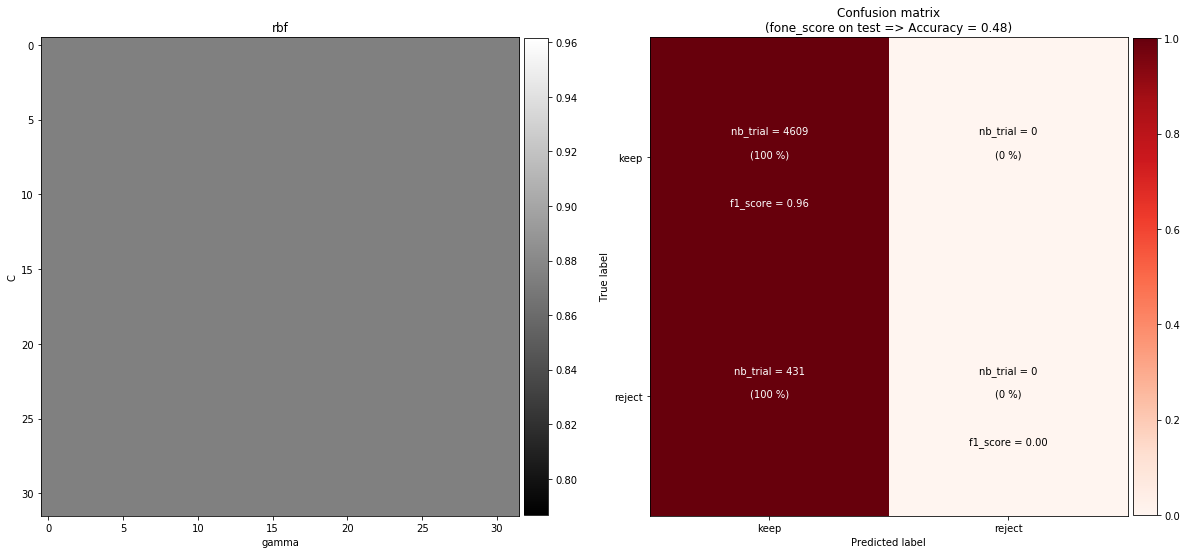

In [9]:
l_ = ['nb_nan', 'residu', 'aic', 'chisqr', 'redchi', 'nfev', 'bic', 'start_anti', 'maxi', 'latency', 'a_anti', 'tau']
figure(l_)

nb_trial_train : X: 2160, y: 2160	nb_trial_test : X: 5040,  y: 5040
nb_Bad_trial -- y_train : 184 -- y_test : 431
The best parameters are {'C': 374.3871470164367, 'gamma': 6.103515625e-05, 'kernel': 'rbf'} with a score of 0.91


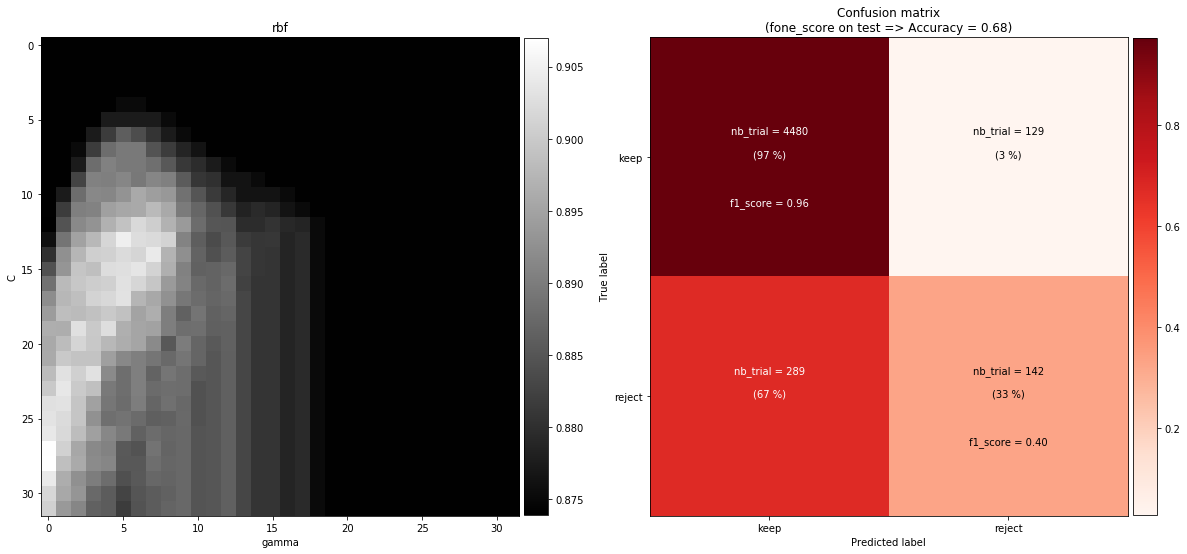

In [10]:
l_ = ['nb_nan', 'residu', 'start_anti',       'latency', 'a_anti', 'tau']
figure(l_)

nb_trial_train : X: 2160, y: 2160	nb_trial_test : X: 5040,  y: 5040
nb_Bad_trial -- y_train : 184 -- y_test : 431
The best parameters are {'C': 1024.0, 'gamma': 8.926085162554662e-05, 'kernel': 'rbf'} with a score of 0.90


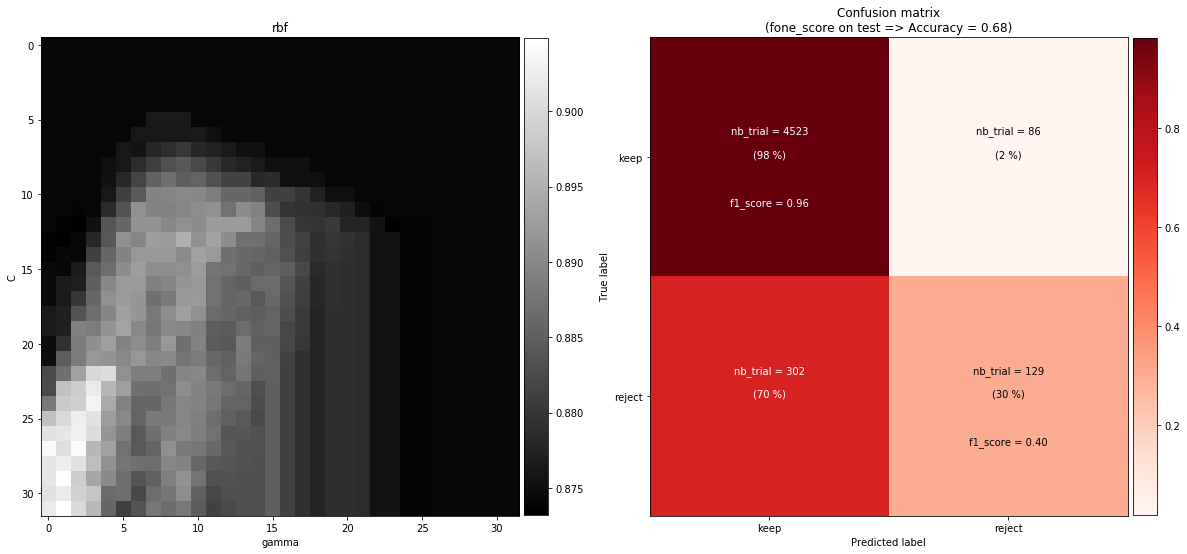

In [11]:
l_ = ['nb_nan', 'residu', 'start_anti',          'a_anti', 'tau']
figure(l_)

nb_trial_train : X: 2160, y: 2160	nb_trial_test : X: 5040,  y: 5040
nb_Bad_trial -- y_train : 184 -- y_test : 431
The best parameters are {'C': 374.3871470164367, 'gamma': 6.103515625e-05, 'kernel': 'rbf'} with a score of 0.91


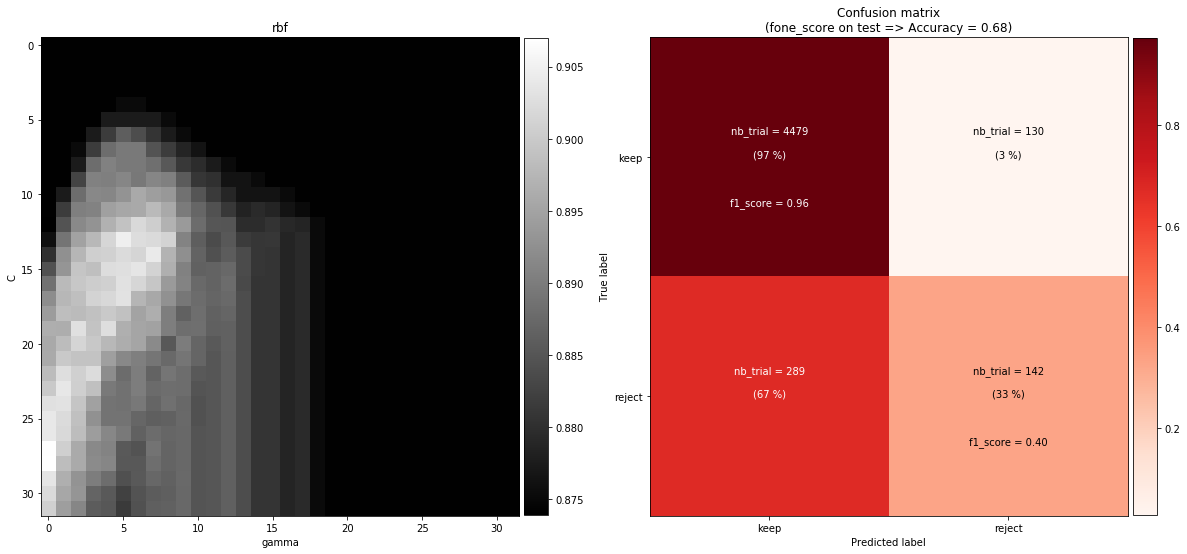

In [12]:
l_ = [        'residu', 'start_anti', 'latency', 'a_anti', 'tau']
figure(l_)

# reporting...